# Data Exploration
This notebook continues the exploration started in part B (data processing) by conducting univariate, bivariate and multivariate analysis and answering the following questions:
1. What is the frequency of new reviews across time? 
2. Does the type of review (positive or negative), purchase place and type matter?
3. Do positive/negative reviews have more comments?
4. Do positive/negative reviews receive more votes_up or votes_funny?
5. Do positive/negative reviews have more playtime at the review time?
6. On average, do people that leave positive reviews play more after leaving the review? Calculate difference between review playtime and playtime at review extraction and create a standardized measure by dividing by the number of months.
7. On average, do people that review more games, recommend the game?
8. On average, do people that own more games, recommend the game?
9. Optional: Create a feature that indicates the launch of a new patch and assess whether a new patch affects the frequency and type of reviews.

Readings:<br>
- https://medium.com/@yennhi95zz/outlier-detection-and-handling-with-python-techniques-and-examples-3094778ef4e
- https://towardsdatascience.com/a-data-scientists-essential-guide-to-exploratory-data-analysis-25637eee0cf6
- https://python.plainenglish.io/best-practices-for-exploratory-data-analysis-in-data-science-1dd645ce3a3e




In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") #temporary solution for a bug in matplotlib v.3.7.2

In [2]:
# Loading the data
gameid=892970
data= pd.read_csv("Data/"+str(gameid)+"_clean.csv")
data.head()

,recommendationid,review,recommended,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,steamid,...,num_reviews,timestamp_created_utc,timestamp_updated_utc,last_played_utc,playtime_forever_hour,playtime_last_two_weeks_hour,playtime_at_review_hour,timestamp_created_utc_ym,timestamp_updated_utc_ym,last_played_utc_ym
0,140348666,I played this for 99 minutes EXACTLY. and I HA...,False,0,0,0.00000,0,False,False,76561198090007828,...,78,2023-06-19 18:59:39,2023-06-19 18:59:39,2021-02-28 11:10:11,1.6,0.0,1.6,2023-06,2023-06,2021-02
1,140347990,"this game is amazing, and even better with the...",True,0,0,0.00000,0,True,False,76561199501472502,...,3,2023-06-19 18:46:33,2023-06-19 18:46:33,2023-06-19 19:24:03,29.8,29.8,29.2,2023-06,2023-06,2023-06
2,140347860,GAME IS horrible gave me fucking cancer sound,False,1,0,0.52381,1,True,False,76561199469648869,...,1,2023-06-19 18:43:53,2023-06-19 18:43:53,2023-06-19 18:42:45,19.4,3.0,19.4,2023-06,2023-06,2023-06
3,140345029,The only bad thing about this game is the amou...,True,0,0,0.00000,0,True,False,76561198082594466,...,4,2023-06-19 17:47:35,2023-06-19 17:47:35,2023-06-19 17:48:05,384.8,0.0,384.8,2023-06,2023-06,2023-06
4,140343169,nice,True,0,0,0.00000,0,True,False,76561198112578500,...,2,2023-06-19 17:09:31,2023-06-19 17:09:31,2023-06-19 19:13:12,49.7,2.0,47.6,2023-06,2023-06,2023-06


### Before exploring each question using manual EDA techniques, I will use the ProfileReport function from ydata_profiling library to output an automated EDA profile analysis using this dataset

In [9]:
def auto_profiling(data, title, file_out):
    from ydata_profiling import ProfileReport
    profile=ProfileReport(data, title=title)
    profile.to_file(file_out)
auto_profiling(data,title="Valheim's Steam Review EDA", file_out="Analysis/Valheim_auto_eda.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

> While exploring the ProfileReport output, I observe the following:
> - there four different **data types**: numeric, text, boolean and date;
> - existance of **skewed and imbalanced** features: recommended, votes_up, votes_funny, comment_count, received_for_free, num_reviews;
> - prevalence of **zeros**: votes_up, votes_funny, weighted_vote_score, comment_count, num_games_owned, playtime_last_two_weeks_hour.


> **Next**: an in-depth manually EDA will be conducted which aims to explore these high-level observations and to answer the 10 questions presented in first cell of the notebook.

---
### 1. What is the frequency of new reviews across time? 

To answer this question, I will start by plotting the total number of reviews across time (year-month as unit).

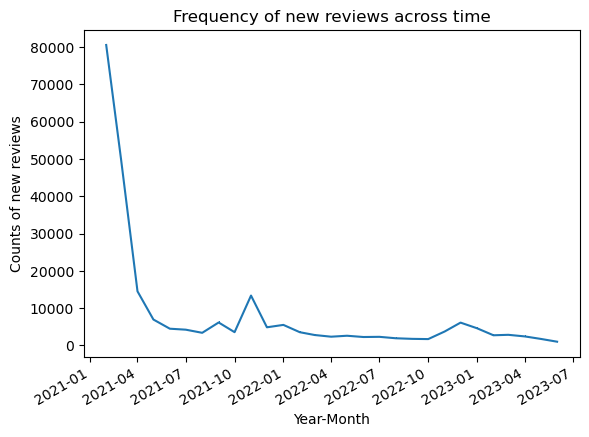

In [12]:
y=data['timestamp_created_utc_ym'].value_counts(sort=False)
y.index=pd.to_datetime(y.index)

fig, ax = plt.subplots()
ax.plot_date(y.index,y.values, fmt=",-")
ax.set(title = "Frequency of new reviews across time",
       xlabel = "Year-Month",
       ylabel = "Counts of new reviews")
fig.autofmt_xdate()
plt.show()

> **Observation**: There seems to be a high number of reviews in the first 3 months since the game was available for review. <br>
> **Next**: Let's look at total reviews created before and after April 2021

In [4]:
# total number of reviews created before or on April 2021 
y.loc[y.index <= '2021-04'].sum()

145017

In [5]:
y.tail(3)

2021-04-01    14509
2021-03-01    49923
2021-02-01    80585
Name: timestamp_created_utc_ym, dtype: int64

> **Observation**: In the first 3 months of availability, 145,017 new reviews were added by users (out of the 243,796) which constitutes ~60% of total reviews:
> - Feb 2021 - 80,585 reviews 
> - March 2021 - 49,923 reviews
> - April 2021 - 14,509 reviews

In [13]:
# After the first 3 months of availability, what are the months with the highest number of new reviews:
y.loc[y.index > '2021-04'].nlargest(5)

2021-11-01    13370
2021-05-01     6941
2021-09-01     6149
2022-12-01     6113
2022-01-01     5502
Name: timestamp_created_utc_ym, dtype: int64

---
### 2. Does the type of review (positive or negative), purchase place and type matter?
To answer this question, I will mainly use stacked histograms. 

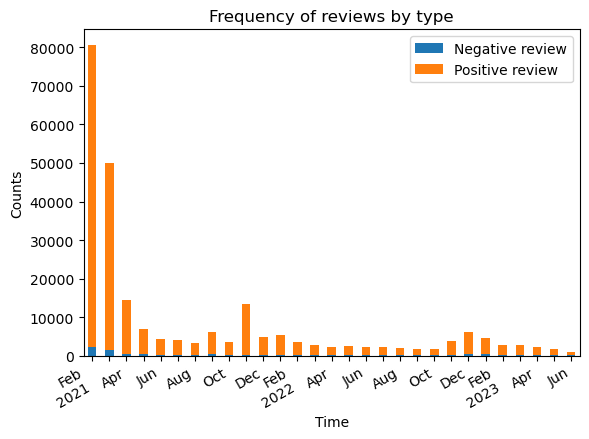

In [5]:
import matplotlib.ticker as ticker #I will use tickers to cluster months for readability

def recommend_plot(columns, var_desc, legend_desc):
    ax = columns.plot(kind='bar',stacked=True)
    time_voted.index=pd.to_datetime(time_voted.index)
    ax.set_xlabel("Time") 
    ax.set_ylabel("Counts") 
    ax.set_title("Frequency of " +var_desc)
    ax.legend(legend_desc)
    # Working with tickers on x axis
    ticklabels = ['']*len(time_voted.index) # Making most of the ticklabels empty 
    ticklabels[::2] = [item.strftime('%b') for item in time_voted.index[::2]] # Every 2th ticklable shows the month
    ticklabels[::12] = [item.strftime('%b\n%Y') for item in time_voted.index[::12]] # Every 12th ticklabel includes the year
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate()
    plt.show()
    
time_voted=data[['timestamp_created_utc_ym', 'recommended']].value_counts(sort=False).unstack()
recommend_plot(time_voted, 'reviews by type', ["Negative review","Positive review"])

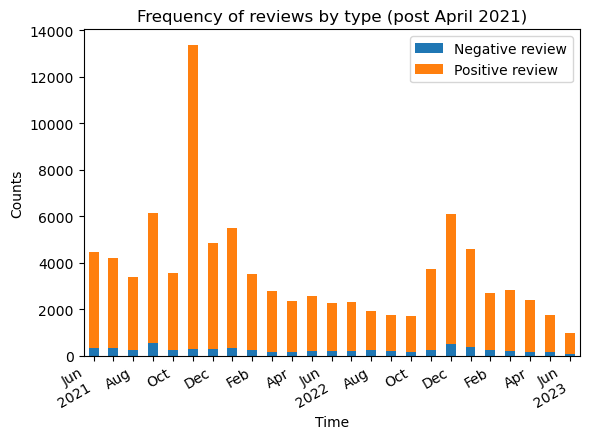

In [4]:
time_voted=data[['timestamp_created_utc_ym', 'recommended']].loc[data['timestamp_created_utc_ym'] >= '2021-05-01'
                                                                ].value_counts(sort=False).unstack()
recommend_plot(time_voted, 'reviews by type (post April 2021)', ["Negative review","Positive review"])

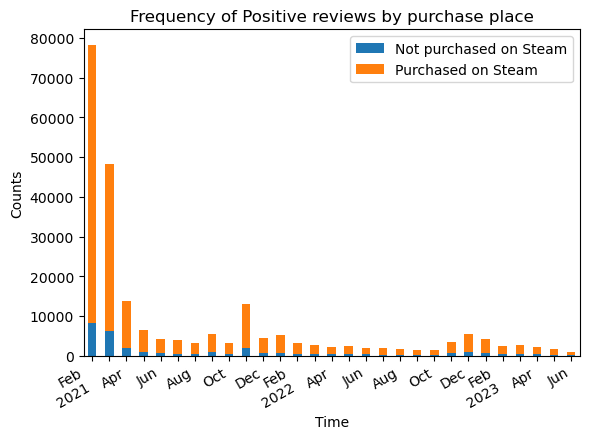

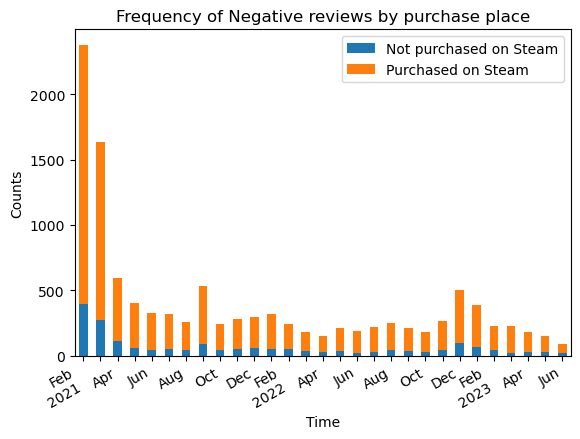

In [7]:
time_voted_dict={'Positive':[True, 'ax1'], 'Negative':[False, 'ax2']}
for key,value in time_voted_dict.items():
        df=data[['timestamp_created_utc_ym','steam_purchase']].loc[data['recommended']==value[0]].value_counts(sort=False).unstack()
        recommend_plot(df, key+' reviews by purchase place', ["Not purchased on Steam","Purchased on Steam"])


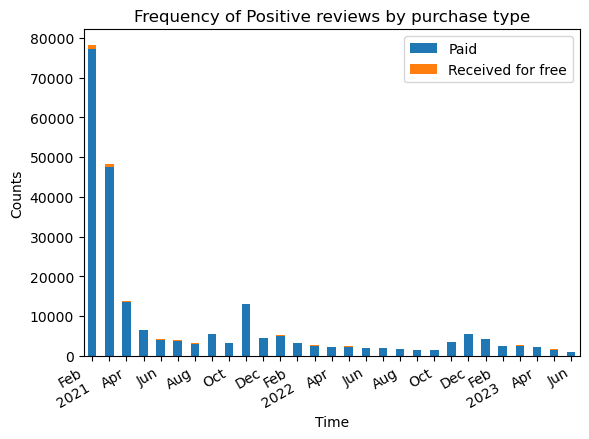

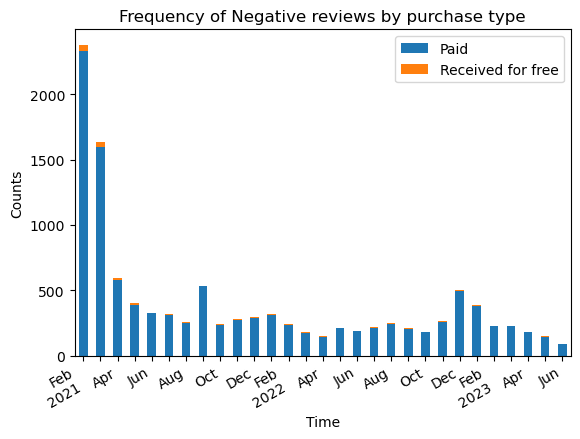

In [8]:
for key,value in time_voted_dict.items():
        df=data[['timestamp_created_utc_ym','received_for_free']].loc[data['recommended']==value[0]
                                                                     ].value_counts(sort=False).unstack()
        recommend_plot(df, key+' reviews by purchase type', ["Paid","Received for free"])

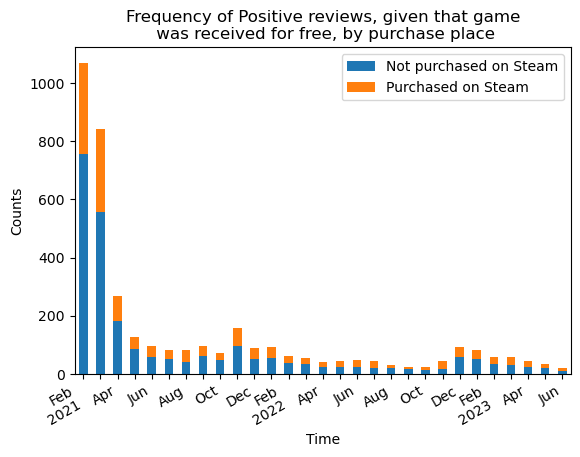

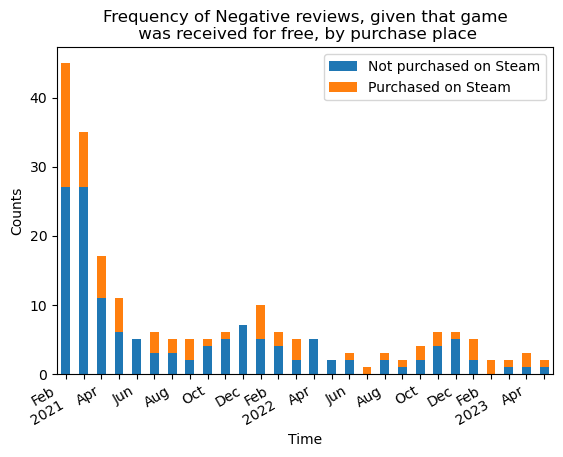

In [11]:
for key,value in time_voted_dict.items():
    df=data[['timestamp_created_utc_ym','steam_purchase']].loc[(data['recommended']==value[0])&(data['received_for_free']==True)
                                                              ].value_counts(sort=False).unstack()
    recommend_plot(df, key+' reviews, given that game\n was received for free, by purchase place', 
                   ["Not purchased on Steam","Purchased on Steam"])

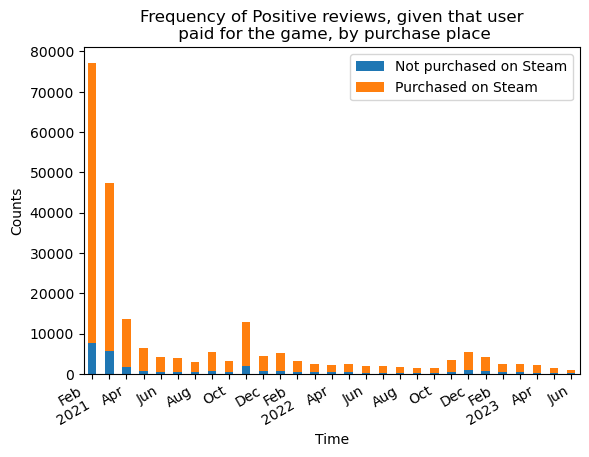

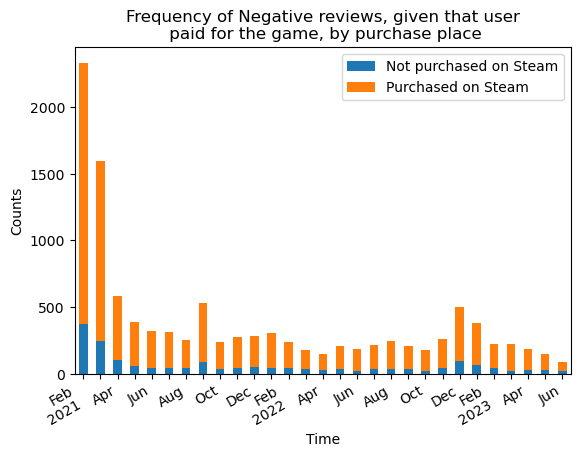

In [12]:
for key,value in time_voted_dict.items():
    df=data[['timestamp_created_utc_ym','steam_purchase']].loc[(data['recommended']==value[0])&(data['received_for_free']==False)
                                                              ].value_counts(sort=False).unstack()
    recommend_plot(df, key+' reviews, given that user\n paid for the game, by purchase place', 
                   ["Not purchased on Steam","Purchased on Steam"])

> **Answer**:
- Purchase location: majority of reviews have purchased the products on Steam. The type of review (positive or negative) does not impact from where the game was purchased.
- Purchase type (free or paid): same situation as in the case of purchase location - majoritaty of reviews (both positive and negative) are created by users who paid for the game

---
### 3. Do positive/negative reviews have more comments?
To explore this question, I will use: 
- boxplot/violinplots as I am working with boolean features;
- outliers identification methods as I am explorting skewed distributions with potential long tails;
- ratio calculations as I am looking at imbalanced features.

In [16]:
#Total number of comments
data['comment_count'].sum()

9852

<Axes: xlabel='recommended', ylabel='comment_count'>

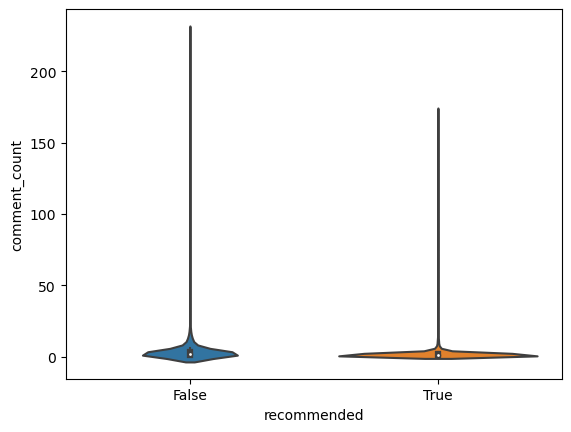

In [3]:
## Boxplots to visualize the distribution of comments by review type
#df=data[['voted_up','comment_count']]
df=data[['recommended','comment_count']].loc[data['comment_count']>0] #filtering out reviews without any comments
sns.violinplot(df,x="recommended", y="comment_count")

> Visually, the violin plots indicate the existance of several outlier observations → I will use different approches to identify outliers while keeping in mind that the distribution is right-skewed

#### Outlier identification methods

##### A. Z scores

<Axes: xlabel='recommended', ylabel='comment_count'>

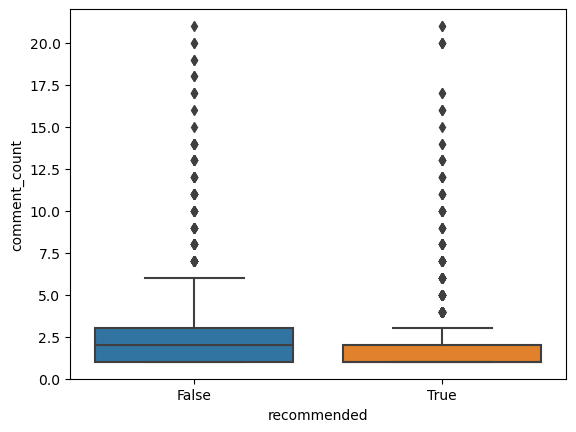

In [4]:
def z_scores_detection_outliers(dataset, column_name, threshold=3):
    z_scores = (dataset[column_name] - dataset[column_name].mean()) /dataset[column_name].std()
    return dataset[~(z_scores > threshold)]
df_no_outliers=z_scores_detection_outliers(df, "comment_count")
sns.boxplot(df_no_outliers,x="recommended", y="comment_count")

In [6]:
print("Feature shape before outliers removal using Z scores: {}".format(df["comment_count"].shape))
print("Feature shape after outliers removal using Z scores: {}".format(df_no_outliers["comment_count"].shape))

Feature shape before outliers removal using Z scores: (4197,)
Feature shape after outliers removal using Z scores: (4162,)


In [7]:
# Number of outliers removed based on the Z score threshold (3 standard deviations from the mean)
df["comment_count"].shape[0]-df_no_outliers["comment_count"].shape[0]

35

In [8]:
# Highest number of comments per review that is below the Z score threshold
df_no_outliers["comment_count"].max()

21

> Using the Z score method for outliers' identification,  we found that 35 observations were above 3 standard deviations from the mean (Z score threshold) or having more than 21 comments.

In [14]:
#Outlier observations that are above 3 standard deviations from the mean
df[df["comment_count"]> 21].sort_values(by="comment_count")

,recommended,comment_count
26617,True,22
33843,True,22
97632,True,23
24285,True,24
42119,True,25
77893,False,25
195479,True,26
149692,False,27
241592,True,28
243786,True,28


##### B. IQR (Interquartile Range)

<Axes: xlabel='recommended', ylabel='comment_count'>

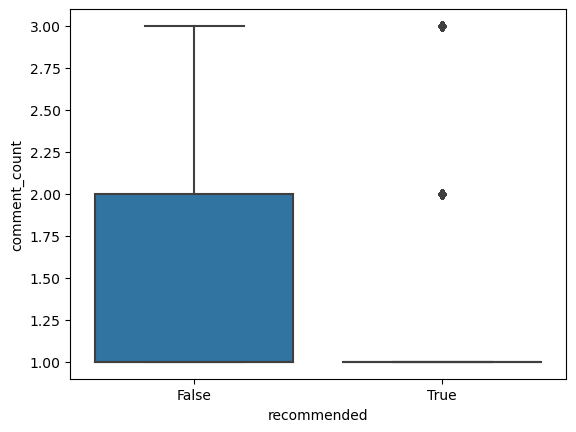

In [5]:
def iqr_detection_outliers(dataset, column_name, range_list=[25, 75]):
    q1, q3 = np.percentile(dataset[column_name], range_list)
    iqr = q3 - q1
    threshold = 1.5
    return dataset[~((dataset[column_name] < q1 - threshold * iqr) | (dataset[column_name] > q3 + threshold * iqr))]

df_no_outliers=iqr_detection_outliers(df,'comment_count')
sns.boxplot(df_no_outliers,x="recommended", y="comment_count")

In [19]:
print("Feature shape before outliers removal using IQR: {}".format(df["comment_count"].shape))
print("Feature shape after outliers removal using IQR: {}".format(df_no_outliers["comment_count"].shape))

Feature shape before outliers removal using IQR: (4197,)
Feature shape after outliers removal using IQR: (3747,)


In [20]:
# Number of outliers removed based on IQR method
df["comment_count"].shape[0]-df_no_outliers["comment_count"].shape[0]

450

In [21]:
# Highest number of comments per review that is below the IQR method threshold
df_no_outliers["comment_count"].max()

3

> Using the IQR method method for outliers' identification,  we found that 450 observations were 1.5 * IQR or having more than 3 comments.

##### C. Winsorization
It is method of imputting/replacing extreme observations with a chosen percentile. In this case, we will replace observations below 5% with 5th percentile value and above 95% with 95th percentile value.

In [21]:
from scipy.stats import mstats
def winsorize_data(dataset, column_name, limits=[0.05, 0.05]):
    winsorized_target = mstats.winsorize(dataset[column_name] , limits=limits)
    updated_dataset=dataset.copy(deep=False)
    updated_dataset[column_name]=winsorized_target
    return updated_dataset


<Axes: xlabel='recommended', ylabel='comment_count'>

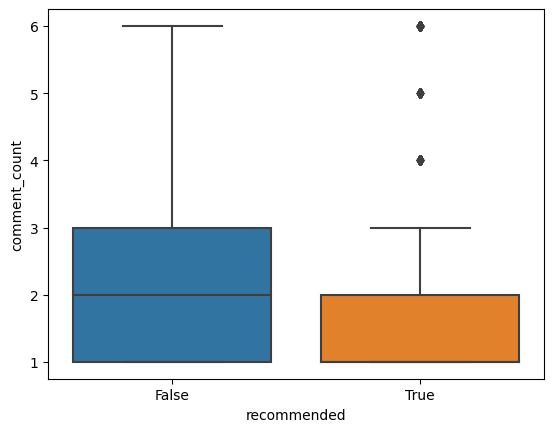

In [7]:
df_no_outliers=winsorize_data(df,'comment_count')
sns.boxplot(df_no_outliers,x="recommended", y="comment_count")

> **Summary** - we used 3 different methods to identify outliers and observed the following:
> - **Z score** method: **35** observations (above 3 standard deviations from the mean) = having more than **21 comments per review**.
> - **IQR score** method: **450** observations (above 3 standard deviations from the mean) = having more than **3 comments per review**.
> - **Winsorization score** method of inputing outliers using the 5th and 95th percentiles values.The effect of this method is replacing all outliers on the right side of the distribution with **6** (value of the 95th percentile)

##### Ratio comment/review
As the 'recommended' feature is imbalanced (95.3% of observations are in 'True' category while only 4.6% are in the 'False' category, I will use ratio methods to explore and compare across categories distributions.

In [24]:
data['recommended'].value_counts()/len(data['recommended'])*100

True     95.300579
False     4.699421
Name: recommended, dtype: float64

In [61]:
summing=pd.pivot_table(data[['recommended','comment_count']], values='comment_count',index='recommended', aggfunc=np.sum)
summing

,comment_count
recommended,
False,3319
True,6533


In [62]:
counting=pd.pivot_table(data[['recommended','comment_count']], values='comment_count',index='recommended', aggfunc='count')
counting

,comment_count
recommended,
False,11457
True,232339


In [63]:
#Ratio across categories by dividing the sum of counts of comment by total reviews and across 'recommended' categories (True/False)
summing/counting

,comment_count
recommended,
False,0.289692
True,0.028118


In [64]:
#out of the total positive or negative reviews, how many have at least 1 comment → dropping all review without any comments
df=data[['recommended','comment_count']].loc[data['comment_count']>0]
pd.pivot_table(df, values='comment_count',index='recommended', aggfunc=np.sum)/pd.pivot_table(df, values='comment_count',
                                                                                              index='recommended', 
                                                                                              aggfunc='count')

,comment_count
recommended,
False,3.623362
True,1.991161


> **Summary** - looking at the ratio comment/review type category, we observe that Steam users have a higher interaction with negative review than with positive review:
> - Overall: there is a ratio of 0.289 comments to a negative review and 0.028 to a positive review;
> - After removing reviews without any comments: ratio of 3.6 comments to a negative reviews and 1.99 to positive reviews

### 4. Do positive/negative reviews receive more votes_up or votes_funny?

In [32]:
#Total number of votes_up
data['votes_up'].sum()

230545

<Axes: xlabel='recommended', ylabel='votes_up'>

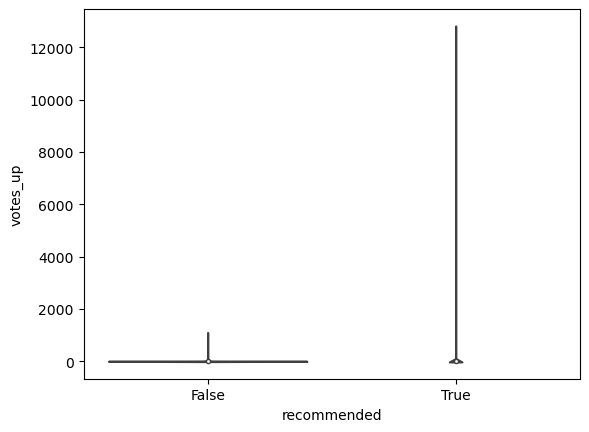

In [8]:
df=data[['recommended','votes_up']].loc[data['votes_up']>0]
sns.violinplot(df,x="recommended", y="votes_up")

<Axes: xlabel='recommended', ylabel='votes_up'>

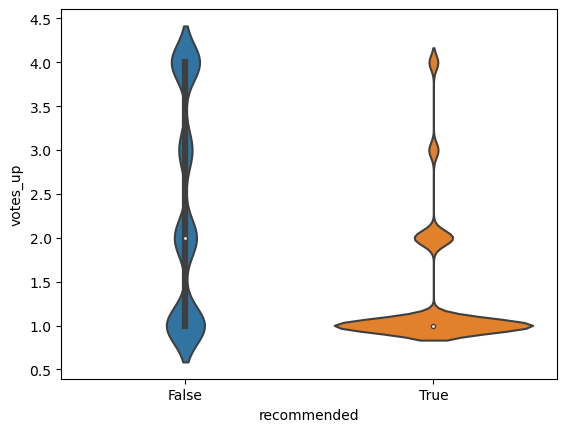

In [39]:
#Ouliers removal based on z score method
df_no_outliers=z_scores_detection_outliers(df, "votes_up")
sns.violinplot(df_no_outliers,x="recommended", y="votes_up")

<Axes: xlabel='recommended', ylabel='votes_up'>

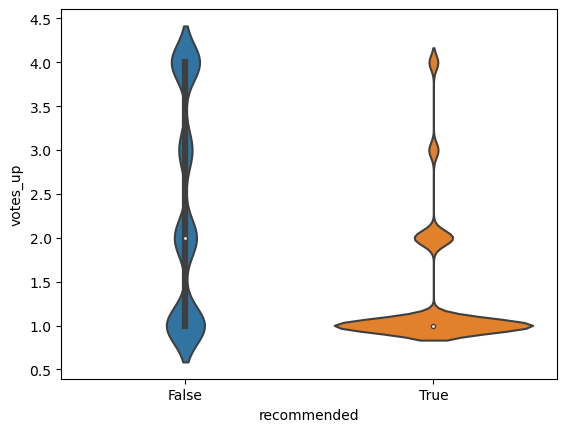

In [40]:
#Oulier inputation based on winsorization
df_no_outliers=winsorize_data(df,'votes_up')
sns.violinplot(df_no_outliers,x="recommended", y="votes_up")

In [66]:
#Total number of votes_up by recommended category
summing=pd.pivot_table(data[['recommended','votes_up']], values='votes_up',index='recommended', aggfunc=np.sum)
summing

,votes_up
recommended,
False,38538
True,192007


In [67]:
#Counting votes_up by recommended category
counting=pd.pivot_table(data[['recommended','votes_up']], values='votes_up', index='recommended', aggfunc='count')
counting

,votes_up
recommended,
False,11457
True,232339


In [68]:
#Ratio of votes_up by recommended category
summing/counting

,votes_up
recommended,
False,3.363708
True,0.826409


>**Positive reviews**
<ul>
    - Total : 232,339<br>
    - Votes up: 192,007<br>
    - Ratio: 0.82 of votes up to a positive review
</ul>

>**Negative reviews**
<ul>
    - Total : 11,457<br>
    - Votes up: 38,538<br>
    - Ratio: 3.36 of votes up to a negative review
</ul>

In [69]:
#Calculating ratio after removing reviews without any votes_up
df=data[['recommended','votes_up']].loc[data['votes_up']>0]
pd.pivot_table(df, values='votes_up',index='recommended', aggfunc=np.sum)/pd.pivot_table(df, values='votes_up', 
                                                                                         index='recommended', 
                                                                                         aggfunc='count')

,votes_up
recommended,
False,5.188905
True,4.187264


> After removing reviews without any votes_up, there is a ratio of 5.1 votes up to a negative review and 4.1 to a positive review → similarly to the case of the comment_count feature, there seems to be a higher iteraction (by voting up a review) with negative reviews than we positive reviews
___
>Next, we look at **votes_funny** feature

In [35]:
#Total number of votes_funny
data['votes_funny'].sum()

48258

<Axes: xlabel='recommended', ylabel='votes_funny'>

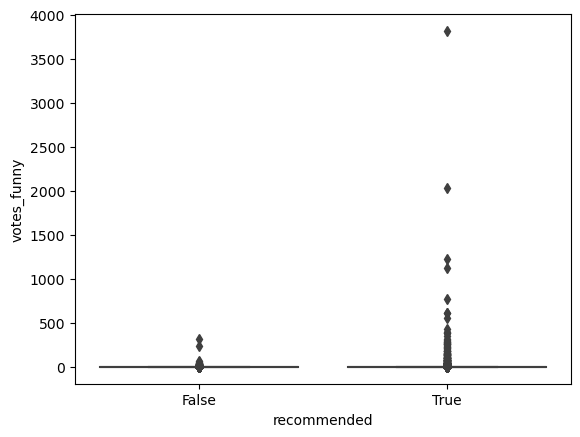

In [70]:
df=data[['recommended','votes_funny']].loc[data['votes_funny']>0]
sns.boxplot(df,x="recommended", y="votes_funny")

<Axes: xlabel='recommended', ylabel='votes_funny'>

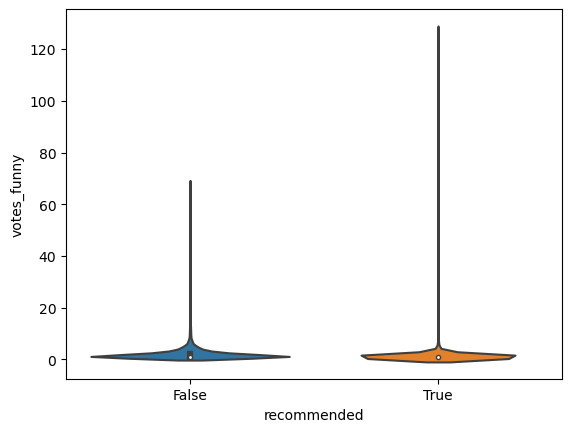

In [71]:
#Ouliers removal based on z score method
df_no_outliers=z_scores_detection_outliers(df, "votes_funny")
sns.violinplot(df_no_outliers,x="recommended", y="votes_funny")

<Axes: xlabel='recommended', ylabel='votes_funny'>

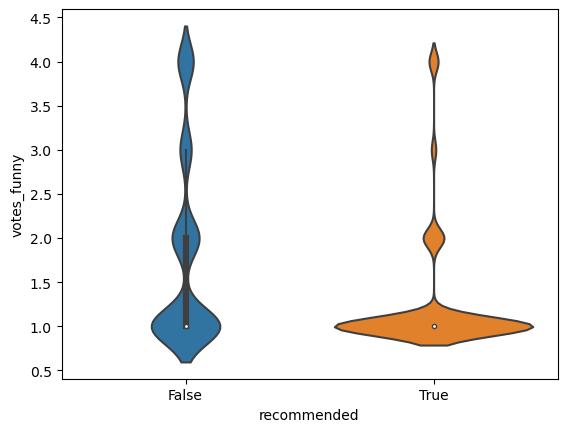

In [72]:
#Oulier inputation based on winsorization
df_no_outliers=winsorize_data(df,'votes_funny')
sns.violinplot(df_no_outliers,x="recommended", y="votes_funny")

In [37]:
df.sort_values('votes_funny', ascending=False).head(10)

,recommended,votes_funny
237831,True,3819
163531,True,2034
81118,True,1225
103323,True,1124
235750,True,777
14243,True,618
195479,True,616
180768,True,552
237529,True,432
101626,True,393


In [73]:
#Ratio of vote funny by recommended category
summing=pd.pivot_table(data[['recommended','votes_funny']], values='votes_funny',index='recommended', aggfunc=np.sum)
counting=pd.pivot_table(data[['recommended','votes_funny']], values='votes_funny', index='recommended', aggfunc='count')
summing/counting

,votes_funny
recommended,
False,0.793052
True,0.168598


In [74]:
#Calculating ratio after removing reviews without any vote funny 
df=data[['recommended','votes_funny']].loc[data['votes_funny']>0]
pd.pivot_table(df, values='votes_funny',index='recommended', aggfunc=np.sum)/pd.pivot_table(df, values='votes_funny',
                                                                                            index='recommended', 
                                                                                            aggfunc='count')

,votes_funny
recommended,
False,2.351449
True,3.725699


> Ratios for votes_funny feature:
> - Overall: 0.16 votes_funny to a positive review and 0.79 votes funny to a negative review
                      
> - After removing reviews without any votes_funny: 3.72 votes funny to a positive review and 2.35 votes_funny to a negative review

### 5. Do positive/negative reviews have more playtime at the review time?

<Axes: xlabel='recommended', ylabel='playtime_at_review_hour'>

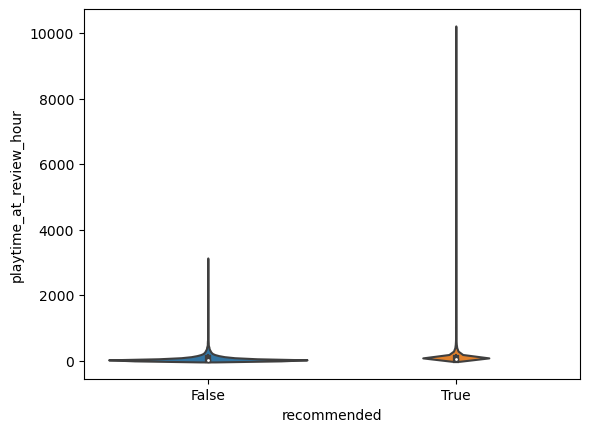

In [9]:
df=data[['recommended','playtime_forever_hour','playtime_at_review_hour']]
sns.violinplot(df,x="recommended", y="playtime_at_review_hour")

In [10]:
#Total number of hours spent playing in total and at review time by review type
x=pd.pivot_table(data[['recommended','playtime_forever_hour','playtime_at_review_hour']], 
                 values=['playtime_forever_hour','playtime_at_review_hour'], index='recommended', aggfunc=np.sum)
#x
#Total number of positive & negative reviews
y=pd.pivot_table(data[['recommended','playtime_forever_hour','playtime_at_review_hour']], 
                 values=['playtime_forever_hour','playtime_at_review_hour'], index='recommended', aggfunc='count')
#y
#Ratio of hours spent playing in total and at review time by review type
x/y

,playtime_at_review_hour,playtime_forever_hour
recommended,,
False,65.317989,111.389500
True,69.421606,192.183449


> On average, reviewers who **recommends** the game tend to spent slightly more time playing the game (**69 hours**) than those who don't recommend the game.<br>
> A reviewer who **doesn't recommend** the game spends, on average, **65 hours before leaving a review**

In [11]:
df=data[['recommended','playtime_at_review_hour']]
df_no_outliers=winsorize_data(df,'playtime_at_review_hour')
x=pd.pivot_table(df_no_outliers, values='playtime_at_review_hour', index='recommended', aggfunc=np.sum)

y=pd.pivot_table(df_no_outliers, values='playtime_at_review_hour', index='recommended', aggfunc='count')

x/y

,playtime_at_review_hour
recommended,
False,52.986113
True,57.889327


<Axes: xlabel='recommended', ylabel='playtime_at_review_hour'>

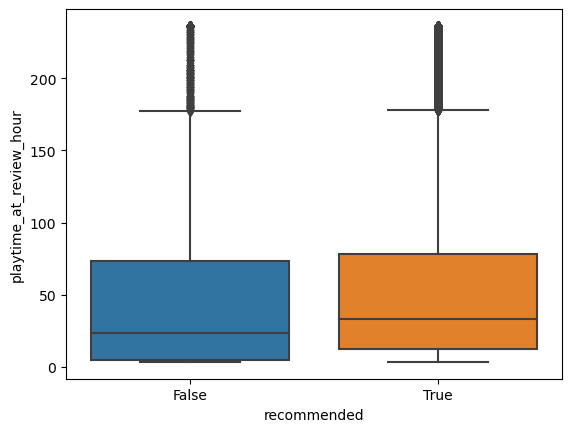

In [15]:
sns.boxplot(df_no_outliers,x="recommended", y="playtime_at_review_hour")

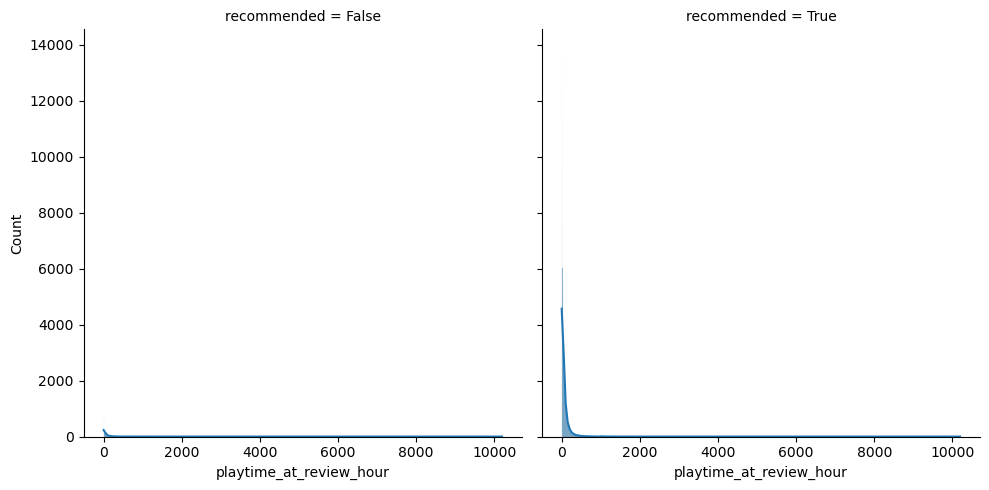

In [21]:
sns.displot(data=df, x="playtime_at_review_hour", col="recommended", kde=True)

> These plots indicate that there are outliers in the dataset that are have a **huge** number of hours played at the time of the review

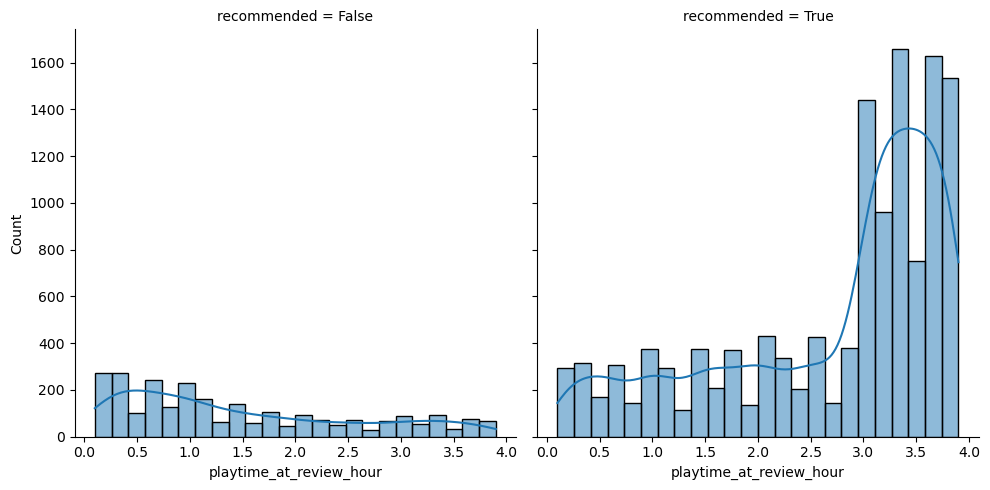

In [13]:
sns.displot(data=df.loc[df["playtime_at_review_hour"] < 4], x="playtime_at_review_hour", col="recommended", kde=True)

In [45]:
#df=data[['recommended','playtime_at_review_hour']]
x=df.loc[df["playtime_at_review_hour"] < 4]
df.sort_values(by="playtime_at_review_hour")

,recommended,playtime_at_review_hour
64071,True,0.1
88805,True,0.1
5758,True,0.1
49662,False,0.1
240498,True,0.1
...,...,...
25372,True,5749.3
48786,True,5904.4
13378,True,5933.9
28604,True,6539.2


> Printing out 2 of the extreme values

In [46]:
data.loc[62885]

recommendationid                                  103983429
review                          STEAM LADDER WORLDWIDE No.1
recommended                                            True
votes_up                                                 12
votes_funny                                               1
weighted_vote_score                                0.578492
comment_count                                             1
steam_purchase                                         True
received_for_free                                     False
steamid                                   76561197978088497
num_games_owned                                       10553
num_reviews                                              64
timestamp_created_utc                   2021-11-26 00:59:50
timestamp_updated_utc                   2022-04-20 17:51:30
last_played_utc                         2023-06-19 19:17:55
playtime_forever_hour                               20276.8
playtime_last_two_weeks_hour            

In [47]:
data.loc[28604]

recommendationid                          121551982
review                                          fun
recommended                                    True
votes_up                                          0
votes_funny                                       0
weighted_vote_score                             0.0
comment_count                                     0
steam_purchase                                 True
received_for_free                             False
steamid                           76561198158760239
num_games_owned                                   0
num_reviews                                       1
timestamp_created_utc           2022-09-01 02:07:01
timestamp_updated_utc           2022-09-01 02:07:01
last_played_utc                 2023-04-15 05:24:59
playtime_forever_hour                        6706.1
playtime_last_two_weeks_hour                    0.0
playtime_at_review_hour                      6539.2
timestamp_created_utc_ym                    2022-09
timestamp_up

According to Steam page, Valheim was released in early access 02/Feb/2021 and there is no information that it was not available before that date on Steam.
See: https://store.steampowered.com/app/892970/Valheim/

I will create a variable that calculates the maximum number of hours or days possible to play at review time (considering that the user would play non-stop)

In [3]:
data['early_access_release_date']=pd.to_datetime('2021-02-02')

data['release_to_review_days']=(pd.to_datetime(data['timestamp_created_utc'])-data['early_access_release_date']).dt.days

data['possible_vs_clocked_days']=data['release_to_review_days']-(data['playtime_at_review_hour']/24)

print(f"Even using a 2 days buffer, there are {len(data.loc[data['possible_vs_clocked_days']<-2]['possible_vs_clocked_days'])} reviews whose clocked played days at review time are higher than the max days posible from the early access release date:")

data.loc[data['possible_vs_clocked_days']<-2]['possible_vs_clocked_days'].sort_values()

Even using a 2 days buffer, there are 59 reviews whose clocked played days at review time are higher than the max days posible from the early access release date:


62885    -127.800000
231786   -113.495833
89755     -44.216667
169485    -24.475000
225175    -23.108333
216182    -22.275000
226715    -20.987500
243703    -19.037500
138953    -17.366667
233314    -14.433333
120287    -13.983333
208098    -12.529167
154406    -11.208333
242790    -10.220833
232214     -9.891667
227676     -9.125000
233394     -9.120833
147241     -9.120833
239689     -8.787500
200934     -7.679167
200681     -7.333333
210544     -6.879167
227501     -6.745833
242925     -6.600000
229006     -6.429167
148959     -6.400000
226436     -6.208333
242934     -6.137500
208233     -5.679167
242915     -5.650000
201759     -5.637500
227385     -5.058333
228488     -5.045833
243445     -4.825000
237146     -4.733333
231127     -4.516667
234607     -4.491667
232604     -4.458333
241553     -4.341667
193844     -4.237500
242846     -4.220833
242034     -4.116667
216085     -3.954167
236485     -3.945833
222491     -3.641667
239076     -3.483333
242663     -3.350000
178930     -3

In [14]:
data['flagged']=[1 if x<-2 else 0 for x in data['possible_vs_clocked_days']]
round(data.loc[data['flagged']==1]['recommended'].value_counts(normalize=True),2)

recommended
True     0.8
False    0.2
Name: proportion, dtype: float64

In [16]:
# population

round(data['recommended'].value_counts(normalize=True),2)

recommended
True     0.95
False    0.05
Name: proportion, dtype: float64

In [ ]:
#possible hypothesis testing for comparing the flagged sample with the overall population

In [17]:
data.columns

Index(['recommendationid', 'review', 'recommended', 'votes_up', 'votes_funny',
       'weighted_vote_score', 'comment_count', 'steam_purchase',
       'received_for_free', 'steamid', 'num_games_owned', 'num_reviews',
       'timestamp_created_utc', 'timestamp_updated_utc', 'last_played_utc',
       'playtime_forever_hour', 'playtime_last_two_weeks_hour',
       'playtime_at_review_hour', 'timestamp_created_utc_ym',
       'timestamp_updated_utc_ym', 'last_played_utc_ym',
       'early_access_release_date', 'release_to_review_days',
       'possible_vs_clocked_days', 'flagged'],
      dtype='object')

### 6. On averge, do people that leave positive reviews play more after leaving the review? 
Calculate difference between review playtime and playtime at review extraction and create a standardized measure by dividing by the number of months.

In [63]:
df_pos=data.loc[data['recommended']==True][['recommended', 'playtime_at_review_hour','playtime_forever_hour','timestamp_created_utc']]

df_pos['playtime_after_review_hour']=df_pos['playtime_forever_hour']-df_pos['playtime_at_review_hour']
df_pos

,recommended,playtime_at_review_hour,playtime_forever_hour,timestamp_created_utc,playtime_after_review_hour
1,True,29.2,29.8,2023-06-19 18:46:33,0.6
3,True,384.8,384.8,2023-06-19 17:47:35,0.0
4,True,47.6,49.7,2023-06-19 17:09:31,2.1
5,True,180.2,180.2,2023-06-19 17:02:25,0.0
6,True,87.3,87.3,2023-06-19 15:58:19,0.0
...,...,...,...,...,...
243791,True,0.1,61.4,2021-02-02 15:24:16,61.3
243792,True,39.8,111.7,2021-02-02 15:22:04,71.9
243793,True,6.6,172.4,2021-02-02 15:13:26,165.8
243794,True,19.2,244.1,2021-02-02 15:07:05,224.9


timestamp_created_utc different than timestamp_updated_utc - or different than last_played_utc

### 7. On average, do people that review more games, recommend the game? 

<Axes: xlabel='recommended', ylabel='num_reviews'>

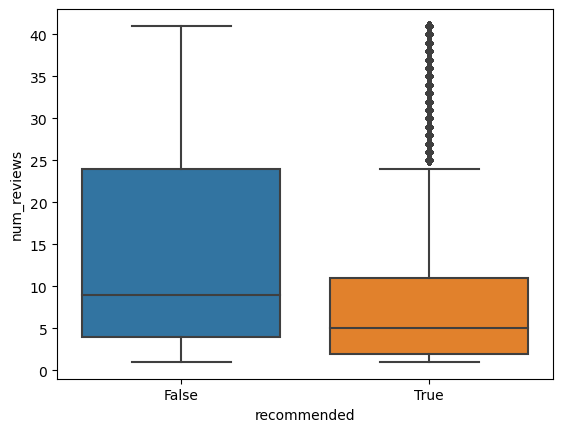

In [23]:
df=data[['recommended','num_reviews']]
sns.boxplot(winsorize_data(df,'num_reviews'),x="recommended", y="num_reviews")

In [25]:
summing=pd.pivot_table(data[['recommended','num_reviews']], values='num_reviews',index='recommended', aggfunc=np.sum)
counting=pd.pivot_table(data[['recommended','num_reviews']], values='num_reviews', index='recommended', aggfunc='count')
summing/counting

,num_reviews
recommended,
False,21.470018
True,10.866320


### 8.On average, do people that own more games, recommend the game?

<Axes: xlabel='recommended', ylabel='num_games_owned'>

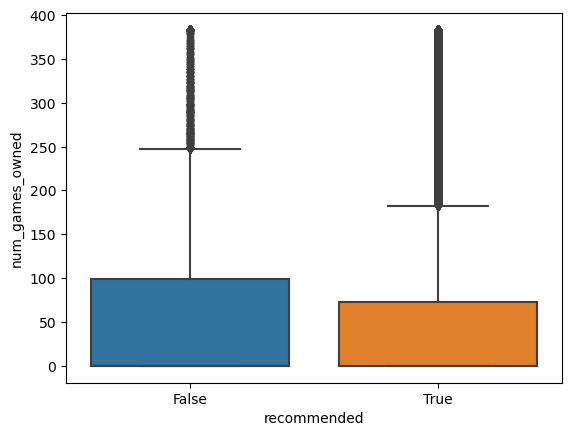

In [24]:
df=data[['recommended','num_games_owned']]
sns.boxplot(winsorize_data(df,'num_games_owned'),x="recommended", y="num_games_owned")

In [26]:
summing=pd.pivot_table(data[['recommended','num_games_owned']], values='num_games_owned',index='recommended', aggfunc=np.sum)
counting=pd.pivot_table(data[['recommended','num_games_owned']], values='num_games_owned', index='recommended', aggfunc='count')
summing/counting

,num_games_owned
recommended,
False,100.497949
True,77.375731


---
### Conclusions
This EDA has focused on answering 10 main questions regarding the Valheim Steam Reviews dataset in order to provide a better understanding of the different features, patterns present in the datset while also identifying potential issues that might impact the next steps.

First, the automated ProfilingReport indicated the prevelance of skewed and imbalanced features

By looking at the reviews' frequency, we noticed that the game had a big reception when it first launched as an early access game as 145,017 or ~60% of total reviews were posted in first 3 months of game's availability.

Majority of reviews have purchased the game on Steam. The type of review (positive or negative) does not impact from where the game was purchased.